## Background

In this project, our group **aimed to develop a predictive model** that utilizes historical payment status and certain demographic information to evaluate the likelihood of credit default.

* **Program used:** Python (beautiful soup, pandas, nltk, sklearn, keras, etc.)

* **Analyses Performed:** Web Scrapping, Data Cleaning/Manipulation, Keyword Extraction, Text Representation(Tokenization, Lemmatization, Vectorization), Machine Learning(Naive Bayes, Logistic Regression, Random Forest, SVC, Neural Network), Deep Learning(Recurrent Neural Network), Validation(Confusion Matrix), and Business Insights

## Introduction

Craigslist is an online platform connecting buyers to sellers. It heavily depends on users returning to its website to increase engagement. Thus, it would be in their best interest to maximize the number of users on their website, or increase the amount of time users spend on Craigslist. An effective way of improving users’ time on a page is by improving their experience. For this project, we decided to focus on user experience in the video gaming section. 

There are several areas for improvement within Craigslist’s video game category: general clutter, inconsistent filtering results, and highly specific filtering options.

Our project aims to improve the user experience in the video gaming category by
offering an improved filtering option by brand name. We will enable customers to search for either Nintendo, Meta, Microsoft, Sony, Arcade, or Other.

## Data Preparation (Web Scrapping)

We used BeautifulSoup4 to scrape 3,011 video game listings from New York, Chicago, Washington DC, Miami, Los Angeles, and Philadelphia. From the title and description we extracted keywords to classify each game brand (e.g Sony, Microsoft) and then stored them in a dictionary of lists.

The dataset consists of 8 columns and 3011 samples without any missing values. 

In [1]:
import pandas as pd

cl = pd.read_csv('all.csv')
cl.head()

,link,posting_id,datetime,city,title,price,place,desc
0,https://miami.craigslist.org/mdc/vgm/d/miami-a...,7414934575,12/1/2021 08:45,miami,Arcade Video Game Machine With Thousands Of P...,$700,(Cutler Bay),\n\nQR Code Link to This Post\n\n\nPRICE IS FI...
1,https://miami.craigslist.org/brw/vgm/d/fort-la...,7414884143,12/1/2021 01:35,miami,sony playstation five - ps5 NEW,$850,(Fort Lauderdale),\n\nQR Code Link to This Post\n\n\nBrand new s...
2,https://miami.craigslist.org/brw/vgm/d/hollywo...,7414875026,12/1/2021 00:25,miami,Battlefield 2042,$50,(Hollywood),\n\nQR Code Link to This Post\n\n\nLike brand ...
3,https://miami.craigslist.org/brw/vgm/d/hollywo...,7414860640,11/30/2021 23:07,miami,Playstation 5 Disc SEALED,$850,(Hollywood),\n\nQR Code Link to This Post\n\n\nBrand new s...
4,https://miami.craigslist.org/brw/vgm/d/hollywo...,7414860692,11/30/2021 23:07,miami,XBOX SERIES X (SEALED) For sale,$780,(Hollywood),\n\nQR Code Link to This Post\n\n\nBrand new s...


In [2]:
cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3011 entries, 0 to 3010
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   link        3011 non-null   object
 1   posting_id  3011 non-null   int64 
 2   datetime    3011 non-null   object
 3   city        3011 non-null   object
 4   title       3011 non-null   object
 5   price       3011 non-null   object
 6   place       3011 non-null   object
 7   desc        3011 non-null   object
dtypes: int64(1), object(7)
memory usage: 188.3+ KB


In [3]:
print(round(cl['city'].value_counts(normalize=True)*100, 2))

losangeles      27.17
newyork         24.44
chicago         17.40
washingtondc    13.28
philadelphia     9.56
miami            8.14
Name: city, dtype: float64


## 1. Data Preprocessing

After we scraped the data, we began the data cleaning process. First, we made each description row into one line and combined with the title column for future analysis. Then, we calculated scores for each description to identify which brand each post belonged to. Finally, we converted the review data into numercial representation. 

#### (1) Cleaning Description Column

In [4]:
# Example of the first description before cleaning

cl_cleaned = cl

cl_cleaned.desc[0]

'\n\nQR Code Link to This Post\n\n\nPRICE IS FIRM\n\nThis is a real Multi Game Arcade packed with over 10,000 games.  \n\nPerfect for a kids room, personal bar or man cave. Includes games for the following systems. \n\n- Arcade games \n- Atari 2600 \n- Atari 5200 \n- Atari 7800 \n- Atari Jaguar \n- Intellivision \n- Colecovision \n- Nintendo Entertainment system \n- Super Nintendo Entertainment System \n- Nintendo Gameboy \n- Nintendo Gameboy Color \n- Sega Master System \n- Sega Genesis \n- Sega 32X \n- Sega Game Gear \n- Turbo Grafx-16 \nAnd more!\n\nNot looking for a trade. Cash only. Pickup only in Homestead.    '

In [5]:
description = []
for d in cl_cleaned['desc']:
    desc_temp = " "
    for s in d.split('\n\n\n')[1].split('\n'):
        desc_temp += s
    description.append(desc_temp)

cl_cleaned['desc'] = description

In [6]:
# After cleaning is performed

cl_cleaned.desc[0]

' PRICE IS FIRMThis is a real Multi Game Arcade packed with over 10,000 games.  Perfect for a kids room, personal bar or man cave. Includes games for the following systems. - Arcade games - Atari 2600 - Atari 5200 - Atari 7800 - Atari Jaguar - Intellivision - Colecovision - Nintendo Entertainment system - Super Nintendo Entertainment System - Nintendo Gameboy - Nintendo Gameboy Color - Sega Master System - Sega Genesis - Sega 32X - Sega Game Gear - Turbo Grafx-16 And more!Not looking for a trade. Cash only. Pickup only in Homestead.    '

In [7]:
# Combine title and description columns

cl_cleaned['review'] = cl_cleaned['title'] + cl_cleaned['desc']

#### (2) Creating Target Variable for each sample

In [8]:
# Manually extracted keywords for each brand

brands = {"Microsoft": ["xbox", "microsoft", "360", "xbox one", " rig ", "x box", "series x", "series s", 
                        "halo","kinect"], 
          "Nintendo": ["wii", "gamecube", "game cube", " ds ", "gameboy", "nintendo", "switch", "cube", 
                       "lite", " dsi ", "2ds", "wii fit", "nunchuck", "game boy", "game boy", "onyx", "oled", 
                       "3ds", "gba","wii remote"], 
          "Sony": ["playstation", "play station", " ps ", "sony", " psp ", "ps4", "ps3", "ps5", "ps vr", "pro", 
                   "ps4 slim"], 
          "Arcade": ["arcade", "atari", "slot machine", "pinball", "machine"], 
          "Meta": ["oculus", "meta", "quest", "quest 2", "vr headset", "rift", "quest 2 elite", "touch controller", 
                   "halo headband", "head strap"]
         }

In [9]:
# We created new columns for all the brands and calculated scores for each sample if any keywords exist in description
# or title. Then we identified which brand each post belongs to based on the brand that had the largest score.
# We created the 'Other' column and assign 0.5 for all samples as default so that samples that had score 0 for all 
# brands can be classfieid to 'Other' category.

import numpy as np

for brand in brands:
    cl_cleaned[brand] = np.repeat(0, len(cl))
    for word in brands[brand]:
        cl_cleaned[brand] += cl_cleaned.title.str.contains(word)
        cl_cleaned[brand] += cl_cleaned.desc.str.contains(word)

cl_cleaned['Other'] = np.repeat(0.5, 3011)
cl_cleaned['Brand'] = cl_cleaned.iloc[:,-6:].idxmax(axis=1)

In [10]:
# After the target values are created 

cl_cleaned.iloc[:10, 7:]

,desc,review,Microsoft,Nintendo,Sony,Arcade,Meta,Other,Brand
0,PRICE IS FIRMThis is a real Multi Game Arcade...,Arcade Video Game Machine With Thousands Of P...,0,0,0,0,0,0.5,Other
1,Brand new sealed,sony playstation five - ps5 NEW Brand new seal...,0,0,3,0,0,0.5,Sony
2,Like brand new also still in plastic and for ...,Battlefield 2042 Like brand new also still in ...,0,0,0,0,0,0.5,Other
3,"Brand new sealed, only willing to meet at a g...","Playstation 5 Disc SEALED Brand new sealed, on...",0,0,0,0,0,0.5,Other
4,"Brand new sealed, only willing to meet a poli...",XBOX SERIES X (SEALED) For sale Brand new seal...,0,0,0,0,0,0.5,Other
5,$10 eachNo texting CALLS ONLY NO BIDDING OVER...,Nintendo 3DS games $10 eachNo texting CALLS ON...,0,0,0,0,0,0.5,Other
6,"15.00 for allPlease, no emailing or texting f...",Attachables to Nintendo Gameboy 15.00 for allP...,0,0,0,0,0,0.5,Other
7,PLEASECalls only,Ps2 games PLEASECalls only,0,0,0,0,0,0.5,Other
8,Please no texting or emailing with your offer...,PSP Movies or games $10 each Please no texting...,0,0,0,0,0,0.5,Other
9,Both are brand new and sealed.Zelle or cashap...,xbox series x brand new - includes one elite c...,5,2,0,0,0,0.5,Microsoft


#### (3) Creating text representation

In [11]:
# Create review and target dataframes separately
reviews = list(cl['review'])
target = list(cl['Brand'])


# Split the review and target data into train(75%) and test(25%) dataset
from sklearn.model_selection import train_test_split

train_input, test_input, train_y, test_y = train_test_split(reviews, target, random_state=12)

In [12]:
# Checking the length of the train/test data

print("Length of train_input:", len(train_input))
print("Length of test_input:", len(test_input))
print("Length of train_target:", len(train_y))
print("Length of test_target:", len(test_y))

Length of train_input: 2258
Length of test_input: 753
Length of train_target: 2258
Length of test_target: 753


In [13]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Tokenization, and Normalization
review_preprocessed_tokenized = []

lemmatizer = nltk.stem.WordNetLemmatizer()
for review in train_input:
    tokens = nltk.word_tokenize(review.lower())
    lemmatized_token = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha()]
    stopwords_removed = [token for token in lemmatized_token if not token in stopwords.words('english')]
    review_preprocessed_tokenized.append(stopwords_removed)

# Vectorization, training the model and transformation to numerical representations

review_preprocessed = []
for review in review_preprocessed_tokenized:
    review_preprocessed.append(" ".join(review))

vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2)
vectorizer.fit(review_preprocessed)

train_x = vectorizer.transform(train_input)
test_x = vectorizer.transform(test_input)

In [14]:
print(train_x.toarray())
print("Dimension for train_input_transformed:", train_x.shape)
print()
print(test_x.toarray())
print("Dimension for teset_input_transformed:", test_x.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Dimension for train_input_transformed: (2258, 9296)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Dimension for teset_input_transformed: (753, 9296)


## 2. Model Building

#### (1) Naive Bayes Model

The test accuracy is higher than the train accuracy, and both train and test accuracy seems very low. It means that underfitting issue happened. It may indicate the model was too simple that it didn't learn the train data enough. NB model is not the best model, but it is exmtremely simple and fast and usually generate good result. It is a good dependable baseline for text classification. Let's try more complicated models.

In [15]:
from sklearn.naive_bayes import MultinomialNB

NBmodel = MultinomialNB()
NBmodel.fit(train_x, train_y)

NB_train_perf1 = NBmodel.score(train_x, train_y)*100
NB_test_perf1 = NBmodel.score(test_x, test_y)*100

print("Naive Bayes model Train Accuracy:: {:.2f}%".format(NBmodel.score(train_x, train_y)*100))
print("Naive Bayes model Test Accuracy:: {:.2f}%".format(NBmodel.score(test_x, test_y)*100))

Naive Bayes model Train Accuracy:: 68.29%
Naive Bayes model Test Accuracy:: 69.99%


#### (2) Logistic Regression Model

This model doesn't seem to have underfitting or overfitting issue and performed well compared to the previous model.

In [16]:
from sklearn.linear_model import LogisticRegression

Logitmodel = LogisticRegression()
Logitmodel.fit(train_x, train_y)

Logit_train_perf1 = Logitmodel.score(train_x, train_y)*100
Logit_test_perf1 = Logitmodel.score(test_x, test_y)*100

print("Logit model Train Accuracy:: {:.2f}%".format(Logit_train_perf1))
print("Logit model Test Accuracy:: {:.2f}%".format(Logit_test_perf1))

Logit model Train Accuracy:: 80.12%
Logit model Test Accuracy:: 76.63%


We tried different hyperparameters to see if the model generated better result. The result below shows that it had a better test accuracy model, but overfitting seemed to exist. Thus, we choice the first option for Logistic Regression. 

In [17]:
# Logistic Model
from sklearn.linear_model import LogisticRegression

Logitmodel2 = LogisticRegression(C=10, max_iter=1000)
Logitmodel2.fit(train_x, train_y)

Logit_train_perf2 = Logitmodel2.score(train_x, train_y)*100
Logit_test_perf2 = Logitmodel2.score(test_x, test_y)*100

print("Logit model Train Accuracy:: {:.2f}%".format(Logit_train_perf2))
print("Logit model Test Accuracy:: {:.2f}%".format(Logit_test_perf2))

Logit model Train Accuracy:: 99.65%
Logit model Test Accuracy:: 80.48%


#### (3) Ensemble models - Random Forest and Gradient Boosting

The result shows that the Random Forest model performs slightly better than the previous models in terms of the test accuracy, but it has a high overfitting issue.

In [18]:
from sklearn.ensemble import RandomForestClassifier

RFmodel = RandomForestClassifier(bootstrap=True, random_state=42)

RFmodel.fit(train_x, train_y)

RF_train_perf1 = RFmodel.score(train_x, train_y)*100
RF_test_perf1 = RFmodel.score(test_x, test_y)*100

print("RF model Train Accuracy:: {:.2f}%".format(RF_train_perf1))
print("RF model Test Accuracy:: {:.2f}%".format(RF_test_perf1))

RF model Train Accuracy:: 100.00%
RF model Test Accuracy:: 78.75%


Then we tried Gradient Boosting model, one with the default setting and another with hyper parameter tuning. Even though both models seemed to be overfitted to the training dataset, the first option is better than the random forest model. 

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

GBmodel = GradientBoostingClassifier(random_state=42)

GBmodel.fit(train_x, train_y)

GB_train_perf1 = GBmodel.score(train_x, train_y)*100
GB_test_perf1 = GBmodel.score(test_x, test_y)*100

print("GB model Train Accuracy:: {:.2f}%".format(GB_train_perf1))
print("GB model Test Accuracy:: {:.2f}%".format(GB_test_perf1))

GB model Train Accuracy:: 92.96%
GB model Test Accuracy:: 81.01%


In [20]:
from sklearn.ensemble import GradientBoostingClassifier

GBmodel2 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.2, random_state=42)

GBmodel2.fit(train_x, train_y)

GB_train_perf2 = GBmodel2.score(train_x, train_y)*100
GB_test_perf2 = GBmodel2.score(test_x, test_y)*100

print("GB model Train Accuracy:: {:.2f}%".format(GB_train_perf2))
print("GB model Test Accuracy:: {:.2f}%".format(GB_test_perf2))

GB model Train Accuracy:: 100.00%
GB model Test Accuracy:: 79.68%


#### (4) Support Vector Machine

The support vector machine model didn't perform well compared to the previous model. 

In [21]:
from sklearn.svm import LinearSVC
SVMmodel = LinearSVC()

SVMmodel.fit(train_x, train_y)

SVM_train_perf1 = SVMmodel.score(train_x, train_y)*100
SVM_test_perf1 = SVMmodel.score(test_x, test_y)*100

print("SVM model Train Accuracy:: {:.2f}%".format(SVM_train_perf1))
print("SVM model Test Accuracy:: {:.2f}%".format(SVM_test_perf1))

SVM model Train Accuracy:: 99.07%
SVM model Test Accuracy:: 80.88%


#### (5) Neural Network

A neural network model doesn't perform well as well. This is probably because the size of the dataset was too small. This model usually perform well when there is a large size of samples. 

In [22]:
from sklearn.neural_network import MLPClassifier
DLmodel = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(3,2), random_state=1)

DLmodel.fit(train_x, train_y)

DL_train_perf1 = DLmodel.score(train_x, train_y)*100
DL_test_perf1 = DLmodel.score(test_x, test_y)*100

print("DL model Train Accuracy:: {:.2f}%".format(DL_train_perf1))
print("DL model Test Accuracy:: {:.2f}%".format(DL_test_perf1))

DL model Train Accuracy:: 66.92%
DL model Test Accuracy:: 68.92%


#### Deep Learning - (6) Recurrent Neural Network

Lastly, RNN generated the lowest test accuracy result of 25%, which was run in Google Colab due to incompatibility in our laptops.

In [ ]:
docs_x = []
docs_train_x = []
docs_test_x = []
for review in train_input:
    docs_x.append(nltk.word_tokenize(str(review).lower()))
    docs_train_x.append(nltk.word_tokenize(str(review).lower()))
for review in train_input:
    docs_x.append(nltk.word_tokenize(str(review).lower()))
    docs_test_x.append(nltk.word_tokenize(str(review).lower()))

from collections import Counter
words = [j for i in docs_x for j in i]
count_words = Counter(words)
total_words = len(words)
sorted_words = count_words.most_common(total_words)
vocab_to_int = {w: i+1 for i, (w,c) in enumerate(sorted_words)} 

text_int = []
for i in docs_train_x:
    r = [vocab_to_int[w] for w in i]
    text_int.append(r)


text_test_int = []
for i in docs_test_x:
    r = [vocab_to_int[w] for w in i]
    text_test_int.append(r)


from keras.preprocessing import sequence 
from keras.models import Sequential 
from keras.layers import Dense, Embedding, Flatten 
from keras.layers import LSTM
max_features = total_words
maxlen = 250
batch_size = 32

x_train = sequence.pad_sequences(text_int, maxlen=maxlen)
x_test = sequence.pad_sequences(text_test_int, maxlen=maxlen)

encoded_train = [0 if label =='Sony' else 1 if label == "Nintendo" else 2 if label == "Microsoft" else 3 if label == "Arcade" else 4 if label == "Meta" else 5 for label in train_y]
encoded_test = [0 if label =='Sony' else 1 if label == "Nintendo" else 2 if label == "Microsoft" else 3 if label == "Arcade" else 4 if label == "Meta" else 5 for label in test_y]

model = Sequential()
model.add(Embedding(max_features, 20, input_length=maxlen))
model.add(LSTM(100, dropout=0.10, recurrent_dropout=0.10))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train.tolist(), encoded_train, batch_size=batch_size, epochs=2, validation_data=(x_test.tolist(), encoded_test))

In [24]:
RNN_test_perf1 = 25
print("RNN model Test Accuracy: {}%".format(RNN_test_perf1))

RNN model Test Accuracy: 25%


## 3. Evaluation

In conclusion, the best model for this classification problem was Gradient Boosting, with the test accuracy of 81%.

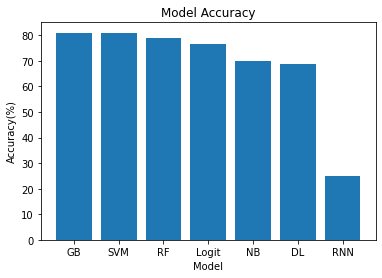

In [27]:
import matplotlib.pyplot as plt

test_accuracy=[NB_test_perf1,Logit_test_perf1,RF_test_perf1, GB_test_perf1, SVM_test_perf1, DL_test_perf1, RNN_test_perf1]
labels=['NB', 'Logit', 'RF', 'GB', 'SVM', 'DL', 'RNN']

test_acc = pd.DataFrame({'Model':labels, 'Accuracy':test_accuracy}).sort_values(by='Accuracy', ascending=False)

plt.bar(x=test_acc['Model'], height=test_acc['Accuracy'])
plt.xlabel("Model")
plt.ylabel("Accuracy(%)")
plt.title("Model Accuracy")
plt.show()

The confusion matrix below shows the number of samples that were correctly classfied or misclassified. It also shows the accuracy rate for each target class (brand). 

In [28]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm_gb = pd.DataFrame(confusion_matrix(test_y, GBmodel.predict(test_x)), 
                     index = ["Arcade", "Meta", "Microsoft", "Nintendo", "Other", "Sony"], 
                     columns = ["Arcade", "Meta", "Microsoft", "Nintendo", "Other", "Sony"])

cm_gb['Sum'] = cm_gb.sum(axis=1)
cm_gb['Accuracy'] = np.repeat(0, len(cm_gb))
for i in range(len(cm_gb)):
    cm_gb.iloc[i,-1] = round(cm_gb.iloc[i,i] / cm_gb.iloc[i,-2], 2)

cm_gb

,Arcade,Meta,Microsoft,Nintendo,Other,Sony,Sum,Accuracy
Arcade,19,0,0,0,5,1,25,0.76
Meta,1,8,1,0,13,0,23,0.35
Microsoft,0,0,56,1,13,0,70,0.80
Nintendo,0,1,1,12,26,1,41,0.29
Other,2,1,13,2,497,4,519,0.96
Sony,1,0,3,2,51,18,75,0.24
